In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import sqlite3
import matplotlib.pyplot as plt
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.0588 - val_loss: 0.0040
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0045 - val_loss: 0.0115
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0040 - val_loss: 0.0077
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0036 - val_loss: 0.0019
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0033 - val_loss: 0.0037
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0030 - val_loss: 0.0015
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0029 - val_loss: 7.0095e-04
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 12/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss:

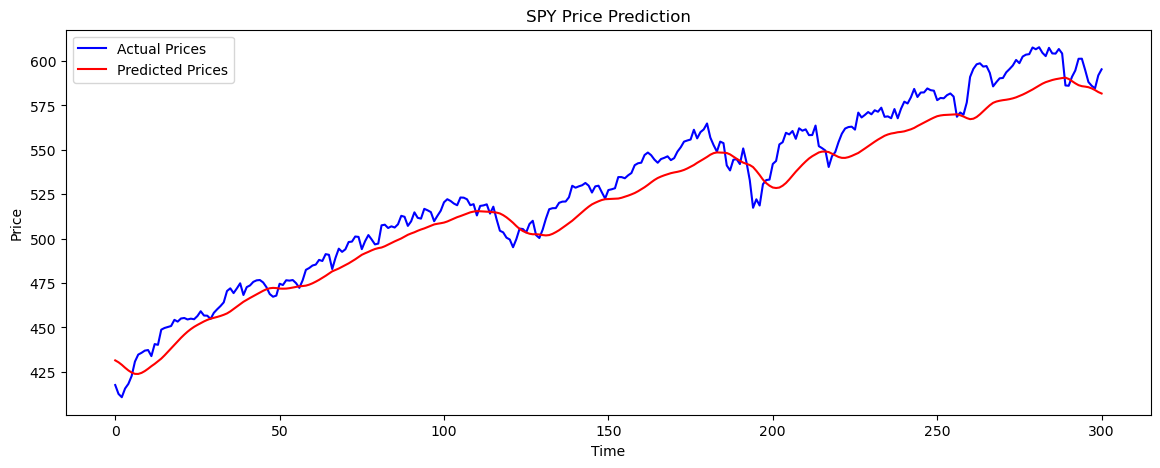

In [8]:

# Load data into an SQLite database
conn = sqlite3.connect('crypto_data.db')

# Load CSV files into the database
crypto_files = {
    "Bitcoin": "Bitcoin_data.csv",
    "Dogecoin": "Dogecoin_data.csv",
    "Ethereum": "Ethereum_data.csv",
    "Litecoin": "Litecoin_data.csv",
    "SPY": "SPY_data.csv",
    "XRP": "XRP_data.csv"
}

for name, file in crypto_files.items():
    df = pd.read_csv(file)
    df.to_sql(name, conn, if_exists='replace', index=False)

# Query the data for SPY
query = """
SELECT Date, PX_HIGH, PX_LOW, PX_LAST 
FROM SPY
WHERE PX_HIGH IS NOT NULL AND PX_LOW IS NOT NULL AND PX_LAST IS NOT NULL;
"""
data = pd.read_sql(query, conn)

# Close the connection
conn.close()

# Sort data by most recent dates
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values(by='Date', ascending=True)

# Data Cleaning and Normalization
data = data[['Date', 'PX_LAST']].dropna()
data.set_index('Date', inplace=True)
scaler = MinMaxScaler(feature_range=(0, 1))
data['PX_LAST'] = scaler.fit_transform(data[['PX_LAST']])

# Prepare data for LSTM
look_back = 60
def create_dataset(dataset):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

values = data['PX_LAST'].values.reshape(-1, 1)
X, Y = create_dataset(values)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split into training and testing
train_size = int(len(X) * 0.75)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

# Build LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 1)))
model.add(Dropout(0.25))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.25))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, Y_train, epochs=20, batch_size=32, validation_data=(X_test, Y_test), verbose=1)

# Evaluate the model
predicted = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted)
actual_prices = scaler.inverse_transform(Y_test.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
r2 = r2_score(actual_prices, predicted_prices)

# Save optimization data
optimization_data = pd.DataFrame({
    'Epoch': range(1, len(history.history['loss']) + 1),
    'Training Loss': history.history['loss'],
    'Validation Loss': history.history['val_loss']
})
optimization_data.to_csv('spy_optimization_log.csv', index=False)

# Display results
print(f"RMSE: {rmse}")
print(f"R^2 Score: {r2}")

dates = data.index[-len(actual_prices):]
# Visualization
plt.figure(figsize=(14, 5))
plt.plot(dates, actual_prices, color='blue', label='Actual Prices')
plt.plot(dates, predicted_prices, color='red', label='Predicted Prices')
plt.title('SPY Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [9]:
# Function to predict future prices
def predict_future_prices(model, last_data, n_future):
    future_prices = []
    current_input = last_data

    for _ in range(n_future):
        # Reshape input to be [samples, time steps, features]
        current_input = np.reshape(current_input, (1, look_back, 1))
        # Predict the next price
        predicted_price = model.predict(current_input)
        # Store the predicted price
        future_prices.append(predicted_price[0][0])
        # Update the input for the next prediction
        current_input = np.append(current_input[0][1:], predicted_price).reshape(-1, 1)

    return future_prices

# Get the last 'look_back' prices from the training data
last_data = values[-look_back:]

# Forecast future prices (e.g., for the next year)
n_future = 365
future_prices = predict_future_prices(model, last_data, n_future)

# Inverse transform the predicted prices to get actual price values
future_prices = scaler.inverse_transform(np.array(future_prices).reshape(-1, 1))

# Prepare dates for the future prices
last_date = data.index[-1]
future_dates = pd.date_range(start=last_date, periods=n_future, freq='D')  # Use daily frequency

# Create a DataFrame for future prices
future_prices_df = pd.DataFrame(data=future_prices, index=future_dates, columns=['Predicted Price'])

# Display the future prices
print(future_prices_df)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━

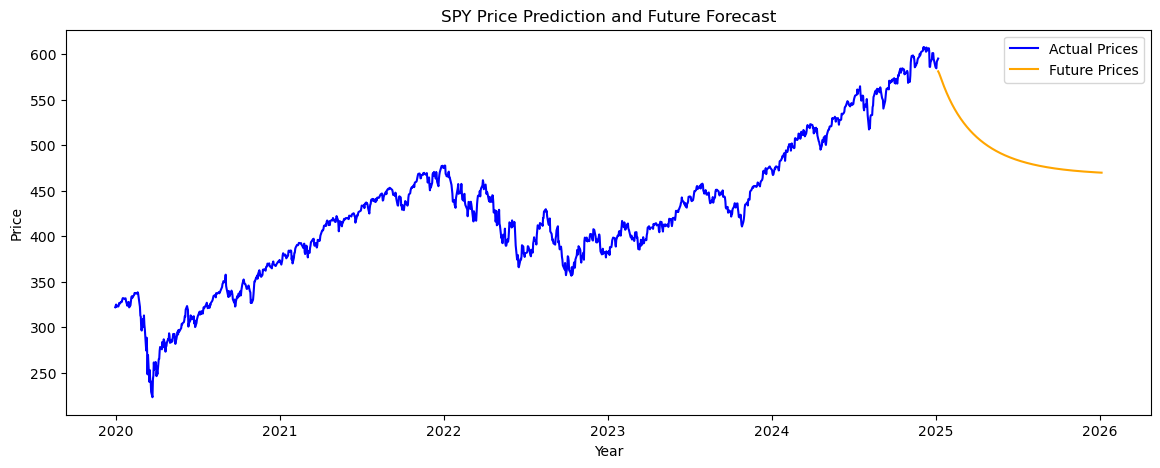

In [10]:
# Optionally, visualize the future prices along with the actual prices
plt.figure(figsize=(14, 5))
plt.plot(data.index, scaler.inverse_transform(values), color='blue', label='Actual Prices')
plt.plot(future_prices_df.index, future_prices_df['Predicted Price'], color='orange', label='Future Prices')
plt.title('SPY Price Prediction and Future Forecast')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()
plt.show()